### Step 1: Retrieving the dataset

In [1]:
# The API link
link = "https://data.cms.gov/resource/ehrv-m9r6.json"

# The app token
key = "oBbcgRhXZS4dqtTJVyz6zQujv"

# Code snippet for data retrieval using python, as provided by the API information page
import pylab
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata
warnings.filterwarnings('ignore')

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cms.gov", key)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cms.gov,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("ehrv-m9r6", limit=163065)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

# Checking the head of the data frame
#results_df.head()

### Step 2: Determine Each State's Top Procedure

In [2]:
# Method 01 exclude tie's

resultGB = results_df.groupby(["provider_state","drg_definition"])#.size().reset_index(name='DRG counts')
drgCtByState = pd.DataFrame(resultGB["provider_id"].count())
drgCtByState.rename(columns = {"provider_id": "Provider Count"}, inplace = True)
drgCtByState["Rank"]= drgCtByState["Provider Count"].rank(method='max')
drgCtByStateRN = drgCtByState.sort_values(by="Rank", ascending = False)
idx = drgCtByStateRN.reset_index().groupby("provider_state")["Provider Count"].idxmax()
drgCtByStateRN.reset_index().loc[idx,].sort_values("provider_state")
result_state_top_proce = results_df.groupby(["provider_state","drg_definition"])
result_state_top_proce = pd.DataFrame(result_state_top_proce["provider_id"].count())
result_state_top_proce.rename(columns = {"provider_id": "Provider Count"}, inplace = True)
result_state_top_proce["Rank"]= drgCtByState["Provider Count"].rank(method='max')
result_state_top_proce = drgCtByState.sort_values(by="Rank", ascending = False)
result_state_top_proce = result_state_top_proce.reset_index().groupby("provider_state")["Provider Count"].idxmax()
result_state_top_proce = drgCtByStateRN.reset_index().loc[idx,].sort_values("provider_state")
del result_state_top_proce["Rank"]
result_state_top_proce = result_state_top_proce.reset_index(drop=True)
result_state_top_proce = result_state_top_proce.rename(columns={"provider_state":"State", "drg_definition":"Procedure Name", "Provider Count":"Procedure Count"})
result_state_top_proce.sort_values(by="Procedure Count", ascending=False).reset_index(drop=True).head()

,State,Procedure Name,Procedure Count
0,CA,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,273
1,TX,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,255
2,FL,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,165
3,NY,292 - HEART FAILURE & SHOCK W CC,158
4,PA,292 - HEART FAILURE & SHOCK W CC,139


### Step 3: Select the top 5 procedure count to determine the relationship between the number of procedures done for a drg code to cost.


In [3]:
pd.options.display.float_format = '${:,.2f}'.format
proce_vs_cost = results_df[["provider_state","drg_definition","average_covered_charges","total_discharges"]]
proce_vs_cost["average_covered_charges"] = proce_vs_cost["average_covered_charges"].apply(pd.to_numeric)
proce_vs_cost["total_discharges"] = proce_vs_cost["total_discharges"].apply(pd.to_numeric)
proce_vs_cost["Cost Per Discharge"] = proce_vs_cost["average_covered_charges"]/proce_vs_cost["total_discharges"]

##### Top No. 1 CA (871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC)

In [4]:
proce_vs_cost = proce_vs_cost.rename(columns={"provider_state":"State", "drg_definition":"Diagnosis","average_covered_charges":"Provider's Average Charge Covered by Medicare","total_discharges":"Total Discharges"})
CA_state = proce_vs_cost[proce_vs_cost["State"] == "CA"].reset_index(drop=True)
CA_state_871 = CA_state[CA_state["Diagnosis"] == "871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC"].reset_index(drop=True)
CA_state_871_desc = CA_state_871.sort_values(by=["Total Discharges"], ascending=False).reset_index(drop=True)
CA_state_871_desc.head()

,State,Diagnosis,Provider's Average Charge Covered by Medicare,Total Discharges,Cost Per Discharge
0,CA,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,"$76,116.17",645,$118.01
1,CA,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,"$97,071.34",597,$162.60
2,CA,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,"$92,706.44",415,$223.39
3,CA,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,"$142,032.24",414,$343.07
4,CA,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,"$53,171.20",385,$138.11


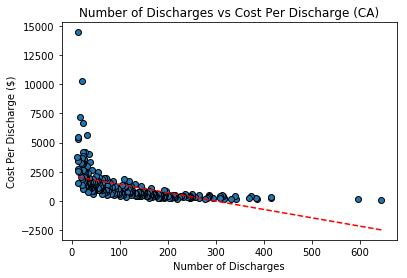

In [5]:
x = CA_state_871_desc["Total Discharges"]
y = CA_state_871_desc["Cost Per Discharge"]
plt.scatter(x, y, edgecolors="black")
plt.title("Number of Discharges vs Cost Per Discharge (CA)")
plt.xlabel("Number of Discharges")
plt.ylabel("Cost Per Discharge ($)")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pylab.plot(x,p(x),"r--")
plt.show()

##### Top No. 2 TX (690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC)

In [6]:
proce_vs_cost = proce_vs_cost.rename(columns={"provider_state":"State", "drg_definition":"Diagnosis","average_covered_charges":"Provider's Average Charge Covered by Medicare","total_discharges":"Total Discharges"})
TX_state = proce_vs_cost[proce_vs_cost["State"] == "TX"].reset_index(drop=True)
TX_state_690 = TX_state[TX_state["Diagnosis"] == "690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC"].reset_index(drop=True)
TX_state_690_desc = TX_state_690.sort_values(by=["Total Discharges"], ascending=False).reset_index(drop=True)
TX_state_690_desc.head()

,State,Diagnosis,Provider's Average Charge Covered by Medicare,Total Discharges,Cost Per Discharge
0,TX,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,"$22,001.54",411,$53.53
1,TX,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,"$23,415.63",352,$66.52
2,TX,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,"$17,661.13",291,$60.69
3,TX,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,"$35,083.95",266,$131.89
4,TX,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,"$28,242.07",252,$112.07


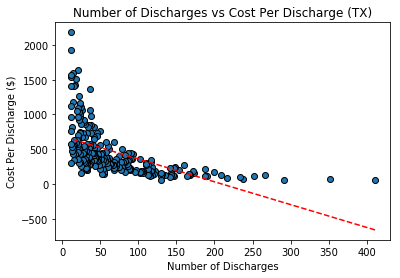

In [7]:
x = TX_state_690_desc["Total Discharges"]
y = TX_state_690_desc["Cost Per Discharge"]
plt.scatter(x, y, edgecolors="black")
plt.title("Number of Discharges vs Cost Per Discharge (TX)")
plt.xlabel("Number of Discharges")
plt.ylabel("Cost Per Discharge ($)")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pylab.plot(x,p(x),"r--")
plt.show()

##### Top No. 3 FL (690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC)

In [8]:
proce_vs_cost = proce_vs_cost.rename(columns={"provider_state":"State", "drg_definition":"Diagnosis","average_covered_charges":"Provider's Average Charge Covered by Medicare","total_discharges":"Total Discharges"})
FL_state = proce_vs_cost[proce_vs_cost["State"] == "FL"].reset_index(drop=True)
FL_state_690 = FL_state[FL_state["Diagnosis"] == "690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC"].reset_index(drop=True)
FL_state_690_desc = FL_state_690.sort_values(by=["Total Discharges"], ascending=False).reset_index(drop=True)
FL_state_690_desc.head()

,State,Diagnosis,Provider's Average Charge Covered by Medicare,Total Discharges,Cost Per Discharge
0,FL,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,"$24,223.62",807,$30.02
1,FL,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,"$21,558.38",317,$68.01
2,FL,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,"$26,282.96",306,$85.89
3,FL,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,"$16,869.59",273,$61.79
4,FL,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,"$19,298.14",262,$73.66


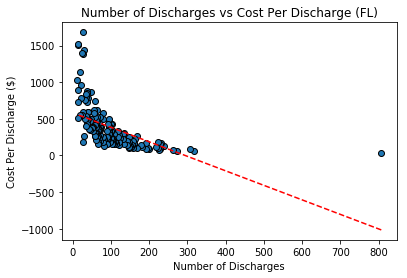

In [9]:
x = FL_state_690_desc["Total Discharges"]
y = FL_state_690_desc["Cost Per Discharge"]
plt.scatter(x, y, edgecolors="black")
plt.title("Number of Discharges vs Cost Per Discharge (FL)")
plt.xlabel("Number of Discharges")
plt.ylabel("Cost Per Discharge ($)")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pylab.plot(x,p(x),"r--")
plt.show()

##### Top No. 4 NY (292 - HEART FAILURE & SHOCK W CC)

In [10]:
proce_vs_cost = proce_vs_cost.rename(columns={"provider_state":"State", "drg_definition":"Diagnosis","average_covered_charges":"Provider's Average Charge Covered by Medicare","total_discharges":"Total Discharges"})
NY_state = proce_vs_cost[proce_vs_cost["State"] == "NY"].reset_index(drop=True)
NY_state_292 = NY_state[NY_state["Diagnosis"] == "292 - HEART FAILURE & SHOCK W CC"].reset_index(drop=True)
NY_state_292_desc = NY_state_292.sort_values(by=["Total Discharges"], ascending=False).reset_index(drop=True)
NY_state_292_desc.head()

,State,Diagnosis,Provider's Average Charge Covered by Medicare,Total Discharges,Cost Per Discharge
0,NY,292 - HEART FAILURE & SHOCK W CC,"$43,839.46",475,$92.29
1,NY,292 - HEART FAILURE & SHOCK W CC,"$51,236.33",421,$121.70
2,NY,292 - HEART FAILURE & SHOCK W CC,"$55,929.32",312,$179.26
3,NY,292 - HEART FAILURE & SHOCK W CC,"$35,323.43",306,$115.44
4,NY,292 - HEART FAILURE & SHOCK W CC,"$49,305.82",256,$192.60


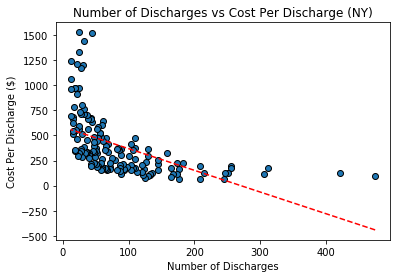

In [11]:
x = NY_state_292_desc["Total Discharges"]
y = NY_state_292_desc["Cost Per Discharge"]
plt.scatter(x, y, edgecolors="black")
plt.title("Number of Discharges vs Cost Per Discharge (NY)")
plt.xlabel("Number of Discharges")
plt.ylabel("Cost Per Discharge ($)")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pylab.plot(x,p(x),"r--")
plt.show()

##### Top No. 5 PA (292 - HEART FAILURE & SHOCK W CC)

In [12]:
proce_vs_cost = proce_vs_cost.rename(columns={"provider_state":"State", "drg_definition":"Diagnosis","average_covered_charges":"Provider's Average Charge Covered by Medicare","total_discharges":"Total Discharges"})
PA_state = proce_vs_cost[proce_vs_cost["State"] == "PA"].reset_index(drop=True)
PA_state_292 = PA_state[PA_state["Diagnosis"] == "292 - HEART FAILURE & SHOCK W CC"].reset_index(drop=True)
PA_state_292_desc = PA_state_292.sort_values(by=["Total Discharges"], ascending=False).reset_index(drop=True)
PA_state_292_desc.head()

,State,Diagnosis,Provider's Average Charge Covered by Medicare,Total Discharges,Cost Per Discharge
0,PA,292 - HEART FAILURE & SHOCK W CC,"$29,413.45",329,$89.40
1,PA,292 - HEART FAILURE & SHOCK W CC,"$22,254.23",306,$72.73
2,PA,292 - HEART FAILURE & SHOCK W CC,"$39,063.05",305,$128.08
3,PA,292 - HEART FAILURE & SHOCK W CC,"$22,521.77",284,$79.30
4,PA,292 - HEART FAILURE & SHOCK W CC,"$12,289.63",281,$43.74


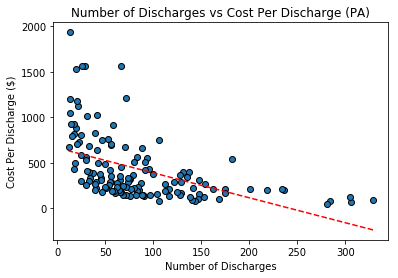

In [13]:
x = PA_state_292_desc["Total Discharges"]
y = PA_state_292_desc["Cost Per Discharge"]
plt.scatter(x, y, edgecolors="black")
plt.title("Number of Discharges vs Cost Per Discharge (PA)")
plt.xlabel("Number of Discharges")
plt.ylabel("Cost Per Discharge ($)")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pylab.plot(x,p(x),"r--")
plt.show()

### Step 4: Select the bottom 5 procedure count to determine the relationship between the number of procedures done for a drg code to cost.


In [14]:
result_state_top_proce.sort_values(by="Procedure Count", ascending=False).reset_index(drop=True).tail()

,State,Procedure Name,Procedure Count
46,AK,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...",8
47,ND,194 - SIMPLE PNEUMONIA & PLEURISY W CC,7
48,DC,812 - RED BLOOD CELL DISORDERS W/O MCC,7
49,VT,191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC,6
50,DE,292 - HEART FAILURE & SHOCK W CC,6


##### Bottom No. 1 DE (292 - HEART FAILURE & SHOCK W CC)

In [15]:
proce_vs_cost = proce_vs_cost.rename(columns={"provider_state":"State", "drg_definition":"Diagnosis","average_covered_charges":"Provider's Average Charge Covered by Medicare","total_discharges":"Total Discharges"})
DE_state = proce_vs_cost[proce_vs_cost["State"] == "DE"].reset_index(drop=True)
DE_state_292 = DE_state[DE_state["Diagnosis"] == "292 - HEART FAILURE & SHOCK W CC"].reset_index(drop=True)
DE_state_292_desc = DE_state_292.sort_values(by=["Total Discharges"], ascending=False).reset_index(drop=True)
DE_state_292_desc.head()

,State,Diagnosis,Provider's Average Charge Covered by Medicare,Total Discharges,Cost Per Discharge
0,DE,292 - HEART FAILURE & SHOCK W CC,"$16,482.74",455,$36.23
1,DE,292 - HEART FAILURE & SHOCK W CC,"$15,608.49",115,$135.73
2,DE,292 - HEART FAILURE & SHOCK W CC,"$13,998.17",89,$157.28
3,DE,292 - HEART FAILURE & SHOCK W CC,"$21,723.54",86,$252.60
4,DE,292 - HEART FAILURE & SHOCK W CC,"$21,474.80",60,$357.91


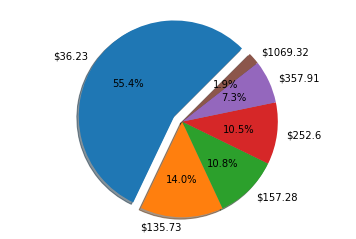

In [16]:
sizes = DE_state_292_desc["Total Discharges"]
explode = (0.1,0,0,0,0,0)
labels=["$36.23", "$135.73", "$157.28", "$252.6", "$357.91", "$1069.32"]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=45)
ax1.axis('equal') 
plt.show()

##### Bottom No. 2 VT (191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC)

In [17]:
proce_vs_cost = proce_vs_cost.rename(columns={"provider_state":"State", "drg_definition":"Diagnosis","average_covered_charges":"Provider's Average Charge Covered by Medicare","total_discharges":"Total Discharges"})
VT_state = proce_vs_cost[proce_vs_cost["State"] == "VT"].reset_index(drop=True)
VT_state_191 = VT_state[VT_state["Diagnosis"] == "191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC"].reset_index(drop=True)
VT_state_191_desc = VT_state_191.sort_values(by=["Total Discharges"], ascending=False).reset_index(drop=True)
VT_state_191_desc.head()

,State,Diagnosis,Provider's Average Charge Covered by Medicare,Total Discharges,Cost Per Discharge
0,VT,191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC,"$16,959.34",85,$199.52
1,VT,191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC,"$11,773.80",68,$173.14
2,VT,191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC,"$13,088.02",50,$261.76
3,VT,191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC,"$12,579.81",43,$292.55
4,VT,191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC,"$12,257.89",19,$645.15


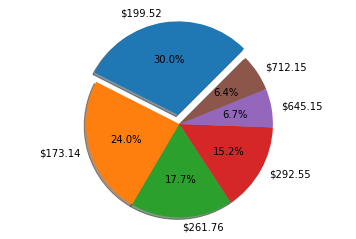

In [18]:
sizes = VT_state_191_desc["Total Discharges"]
explode = (0.1,0,0,0,0,0)
labels=["$199.52","$173.14","$261.76","$292.55","$645.15","$712.15"]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=45)
ax1.axis('equal') 
plt.show()

##### Bottom No. 3 DC (812 - RED BLOOD CELL DISORDERS W/O MCC)


In [19]:
proce_vs_cost = proce_vs_cost.rename(columns={"provider_state":"State", "drg_definition":"Diagnosis","average_covered_charges":"Provider's Average Charge Covered by Medicare","total_discharges":"Total Discharges"})
DC_state = proce_vs_cost[proce_vs_cost["State"] == "DC"].reset_index(drop=True)
DC_state_812 = DC_state[DC_state["Diagnosis"] == "812 - RED BLOOD CELL DISORDERS W/O MCC"].reset_index(drop=True)
DC_state_812_desc = DC_state_812.sort_values(by=["Total Discharges"], ascending=False).reset_index(drop=True)
DC_state_812_desc.head()

,State,Diagnosis,Provider's Average Charge Covered by Medicare,Total Discharges,Cost Per Discharge
0,DC,812 - RED BLOOD CELL DISORDERS W/O MCC,"$21,741.77",147,$147.90
1,DC,812 - RED BLOOD CELL DISORDERS W/O MCC,"$22,996.31",85,$270.54
2,DC,812 - RED BLOOD CELL DISORDERS W/O MCC,"$12,217.08",58,$210.64
3,DC,812 - RED BLOOD CELL DISORDERS W/O MCC,"$15,105.16",53,$285.00
4,DC,812 - RED BLOOD CELL DISORDERS W/O MCC,"$21,984.32",52,$422.78


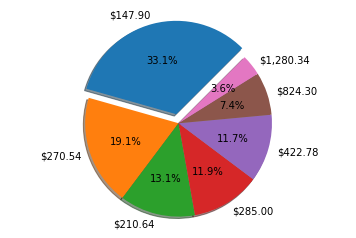

In [20]:
sizes = DC_state_812_desc["Total Discharges"]
explode = (0.1,0,0,0,0,0,0)
labels=["$147.90", "$270.54", "$210.64", "$285.00", "$422.78", "$824.30", "$1,280.34"]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=45)
ax1.axis('equal') 
plt.show()

##### Bottom No. 4 ND (194 - SIMPLE PNEUMONIA & PLEURISY W CC)

In [21]:
proce_vs_cost = proce_vs_cost.rename(columns={"provider_state":"State", "drg_definition":"Diagnosis","average_covered_charges":"Provider's Average Charge Covered by Medicare","total_discharges":"Total Discharges"})
ND_state = proce_vs_cost[proce_vs_cost["State"] == "ND"].reset_index(drop=True)
ND_state_194 = ND_state[ND_state["Diagnosis"] == "194 - SIMPLE PNEUMONIA & PLEURISY W CC"].reset_index(drop=True)
ND_state_194_desc = ND_state_194.sort_values(by=["Total Discharges"], ascending=False).reset_index(drop=True)
ND_state_194_desc.head()

,State,Diagnosis,Provider's Average Charge Covered by Medicare,Total Discharges,Cost Per Discharge
0,ND,194 - SIMPLE PNEUMONIA & PLEURISY W CC,"$12,100.62",87,$139.09
1,ND,194 - SIMPLE PNEUMONIA & PLEURISY W CC,"$12,251.13",81,$151.25
2,ND,194 - SIMPLE PNEUMONIA & PLEURISY W CC,"$12,378.29",71,$174.34
3,ND,194 - SIMPLE PNEUMONIA & PLEURISY W CC,"$10,496.84",52,$201.86
4,ND,194 - SIMPLE PNEUMONIA & PLEURISY W CC,"$11,025.74",51,$216.19


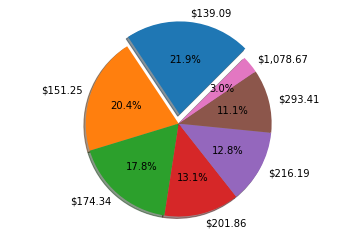

In [22]:
sizes = ND_state_194_desc["Total Discharges"]
explode = (0.1,0,0,0,0,0,0)
labels=["$139.09","$151.25","$174.34","$201.86","$216.19","$293.41","$1,078.67"]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=45)
ax1.axis('equal') 
plt.show()

##### Bottom No. 5 AK (392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC)

In [23]:
proce_vs_cost = proce_vs_cost.rename(columns={"provider_state":"State", "drg_definition":"Diagnosis","average_covered_charges":"Provider's Average Charge Covered by Medicare","total_discharges":"Total Discharges"})
AK_state = proce_vs_cost[proce_vs_cost["State"] == "AK"].reset_index(drop=True)
AK_state_392 = AK_state[AK_state["Diagnosis"] == "392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC"].reset_index(drop=True)
AK_state_392_desc = AK_state_392.sort_values(by=["Total Discharges"], ascending=False).reset_index(drop=True)
AK_state_392_desc.head()

,State,Diagnosis,Provider's Average Charge Covered by Medicare,Total Discharges,Cost Per Discharge
0,AK,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...","$25,227.77",53,$476.00
1,AK,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...","$11,703.02",45,$260.07
2,AK,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...","$23,845.94",35,$681.31
3,AK,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...","$17,382.36",19,$914.86
4,AK,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...","$10,425.55",18,$579.20


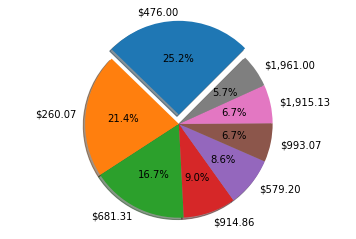

In [24]:
sizes = AK_state_392_desc["Total Discharges"]
explode = (0.1,0,0,0,0,0,0,0)
labels=["$476.00","$260.07","$681.31","$914.86","$579.20","$993.07","$1,915.13","$1,961.00"]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=45)
ax1.axis('equal') 
plt.show()